In [1]:
import os
import time
import random
import sys
from sys import getsizeof
import mne
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import scipy
from scipy import signal
from scipy.signal import find_peaks
import matplotlib
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import filedialog
from itertools import groupby
from operator import itemgetter

## 1. Loading raw EEG data

In [2]:
# load the raw edf file
filename=filedialog.askopenfilename()
raw=mne.io.read_raw_edf(filename,preload=False)

Extracting EDF parameters from E:\EEG_data\Patient2\FA0011HT_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


## 2.1 Call functions for noise detection

Some necessary functions

1. get_data: to cut the raw data into shorter clips

2. DFT_wavelet: to conduct Morlet-wavelet

3. Normalization: to normalize the time-frequency matrix

4. bar_result: to quantify the time-frequency map

5. tf: to merge all functions above

In [3]:
# create the function to extract the data we need
def get_data(raw,ch_names,len_clip):
    
    # get the signal and time vector
    d=raw[ch_names][0]
    t=raw[ch_names][1]
    t=np.reshape(t,newshape=(1,d.shape[1])) # change t into (1,n) array
    # re-map the value to (0,1)
    # 1st, we need to calculate the slope based on formula slope=(out_end-out_start)/(in_end-in_start)
    in_end=np.max(d,axis=1)
    in_start=np.min(d,axis=1)
    out_end=1
    out_start=0
    slope=(out_end-out_start)/(in_end-in_start)
    # 2nd, calculate the new sequence
    d=((d.T-in_start)*slope+out_start).T # with the shape of (4,3600*fs) ideally
    print('The shape of dataset is: '+str(d.shape))
    # adjust the length
    num_clip=int(d.shape[1]/fs/len_clip)
    d=d[:,:int(num_clip*fs*len_clip)]
    t=t[:,:int(num_clip*fs*len_clip)]
    
    # this dataset is too large, so we need to split it into small epochs
    n_clip=int(d.shape[1]/fs/len_clip)
    print('The number of clip is: '+str(n_clip))
    d_list=np.split(d,n_clip,axis=1)
    t_list=np.split(t,n_clip,axis=1)
    
    return d_list,t_list


# create the DFT series of wavelet
def DFT_wavelet(freq,wavetime,sigma,nconv):
    # 1st, create the sine wave
    sine_wave=np.exp(1j*2*np.pi*freq*wavetime)
    # 2nd, create the gaussain window
    gau_win=np.exp(-(np.power(wavetime,2)/(2*np.power(sigma,2))))
    # 3rd, create the wavelet
    wave=sine_wave*gau_win
    
    # do the DFT on the wavelet
    wave_AK=np.fft.fft(wave,nconv)
    # normalize the result
    wave_AK=wave_AK/np.max(wave_AK)
    
    return wave_AK


# create the function to retrun the normalized result
def Normalization(res_list,mode):
    # retrieve parameter
    num_clip=len(res_list) # number of clip
    num_ch=len(res_list[0]) # number of channels, usually 4
    slice_len=res_list[0][0].shape[1] # number of points of each channel (supposed to be len_clip*fs)
    
    # create an empty list
    res_list_norm=[]
    # loop over all clips
    for i in range(num_clip):
        # create an empty list 
        res_list_norm_clip=[]
        # loop over different channels
        for j in range(num_ch):
            # retrieve data (the jth channel of ith clip)
            data=res_list[i][j]
            # use the mean power of this frequency as the baseline of clip i channel j
            baseline=np.mean(data,axis=1) # the shape should be (100,)
            # apply one of the normalization mode
            if mode=='DB normalization':
                ratio=(data.T/baseline).T
                normalized=10*np.log10(ratio)
                res_list_norm_clip.append(normalized)
            
            if mode=='PER normalization':
                ratio=((data.T-baseline)/baseline).T
                normalized=100*ratio
                res_list_norm_clip.append(normalized)
                
        # append it into total list
        res_list_norm.append(res_list_norm_clip)
                
    return res_list_norm


# create a function to return result fot bar plotting and evaluation
def bar_result(res_list_norm,step):
    # retrieve paramters
    num_clip=len(res_list_norm) # number of clip
    num_ch=len(res_list_norm[0]) # number of channels, usually 4
    slice_len=res_list_norm[0][0].shape[1] # length of each channel (supposed to be len_clip*fs)
    
    # the number of steps in each slice
    num_step=int(slice_len/fs/step)
    # create empty lists to store result
    heat_win_t=[]
    cnt_win_t=[]
    # loop over all clips
    for i in range(num_clip):
        # create empty lists to store info channel-wise
        heat_win_clip=[]
        cnt_win_clip=[]
        # loop over all channels
        for j in range(num_ch):
            # get the whole sequnece of jth channel in ith clip
            res=res_list_norm[i][j]
            # reshape the tensor form 2d into 3d
            res=np.reshape(res,newshape=(-1,num_step,int(slice_len/num_step)))
            # compute the average heat in the time window
            heat_win=np.mean(res,axis=(0,2))
            heat_win_clip.append(heat_win)
            # compute the total number of frequency which is greater than threshold
            cnt_win=np.sum(np.mean(res,axis=2)>=0,axis=0)
            cnt_win_clip.append(cnt_win)
            
        # append sublists into lists
        heat_win_t.append(heat_win_clip)
        cnt_win_t.append(cnt_win_clip)
        
    return heat_win_t,cnt_win_t


# create a function to do the T-F analysis
def tf(d_list,wavetime,f,cycle,num_frex,step,mode):
    # retrieve paramters
    num_clip=len(d_list) # number of clip, supposed to be 10
    num_ch=d_list[0].shape[0] # number of channels
    slice_len=d_list[0].shape[1] # length of each channel (supposed to be 3600*fs)
    # parameters for convolution
    ndata=slice_len
    nwin=len(wavetime)
    # the frequency and cycle of wavelet and sigma for gaussain window
    frex=np.linspace(f[0],f[1],num_frex)
    range_cycles=np.linspace(cycle[0],cycle[1],num_frex)
    Sigma=range_cycles/(2*np.pi*frex)
    
    # create an empty list to store the volage and power result
    res_list=[]
    # loop over all clips
    print('Begin to compute t-f power')
    for i in range(num_clip):
        # creata an empty list to store result channel-wise
        res_list_ch=[]
        # get the sequence of ith clip
        data=d_list[i]
        # loop over all channels in this clip
        for j in range(num_ch):
            # get the whole sequnece of jth channel in ith clip
            eeg=d_list[i][j]
            # then, we need to append the data like (reflect,original,ref)
            # get the reflected data
            eeg_flip=np.flip(eeg)
            # concat arrays
            eeg=np.concatenate((eeg_flip,eeg,eeg_flip))
            # apply fft on eeg data
            nconv=3*ndata+nwin-1
            half_wave=int((2*ndata+len(wavetime)-1)/2)
            eeg_AK=np.fft.fft(eeg,nconv)
            # store the result to an numpy array
            res=np.zeros((len(frex),slice_len),dtype=np.float32) # from small freq to large freq
            # loop over wavelet frequency
            for k in range(len(frex)):
                # get the DFT of the wavelet
                wave_AK=DFT_wavelet(frex[k],wavetime,Sigma[k],nconv)
                # convolution in time domain equals to multiplication in f domain
                r=np.fft.ifft(eeg_AK*wave_AK)
                # adjust its' length
                r=r[half_wave:-half_wave]
                # take the magnitude
                res[k,:]=np.abs(r)
            
            # append it into list
            res_list_ch.append(res)
            
        # append it into total list
        res_list.append(res_list_ch)
        # set the counter
        if (i+1)%2==0:
            print(str(np.round(100*(i+1)/num_clip,3))+'% percent of clips have been processed !!!')
    
    # apply either of two normalization function to the result
    print('Begin to normalize power spectrum')
    res_list_norm=Normalization(res_list,mode)
    # return the statistic resulr for plotting
    print('Begin to apply quantify t-f plot')
    heat_win_t,cnt_win_t=bar_result(res_list_norm,step)
    
    return res_list_norm,heat_win_t,cnt_win_t

## 2.2 Load data of selected channel

Set parameters to load the data you want to analyze

In [4]:
# set hyperparameters for loading data
fs=raw.info['sfreq']
ch_names=["POL A13","POL A15","POL H3","POL H6"]
# set the number of clips we need
len_clip=120 # in seconds

# get the data and time vector
d_list,t_list=get_data(raw,ch_names,len_clip)

The shape of dataset is: (4, 7872000)
The number of clip is: 32


## 2.3 Get the TF result

Set parameters to create the sine wave and Gaussian kernel

In [5]:
# time vector for wavelet
wavetime=np.arange(-1,1+1e-08,1/fs)
# frequency range
f=[1,100]
# cycle range of wavelet
cycle=[60,100]
# # number of different frequency and cycles
num_frex=100
# time winddow in bar plotting
step=1 # very crucial parameter
# set the normalization mode
mode='DB normalization'

# set a timer
time_start=time.time()
res_list_norm,heat_win_t,cnt_win_t=tf(d_list,wavetime,f,cycle,num_frex,step,mode)
time_end=time.time()
print('The time it takes is: '+str(np.round(time_end-time_start,2)))

Begin to compute t-f power
6.25% percent of clips have been processed !!!
12.5% percent of clips have been processed !!!
18.75% percent of clips have been processed !!!
25.0% percent of clips have been processed !!!
31.25% percent of clips have been processed !!!
37.5% percent of clips have been processed !!!
43.75% percent of clips have been processed !!!
50.0% percent of clips have been processed !!!
56.25% percent of clips have been processed !!!
62.5% percent of clips have been processed !!!
68.75% percent of clips have been processed !!!
75.0% percent of clips have been processed !!!
81.25% percent of clips have been processed !!!
87.5% percent of clips have been processed !!!
93.75% percent of clips have been processed !!!
100.0% percent of clips have been processed !!!
Begin to normalize power spectrum
Begin to apply quantify t-f plot
The time it takes is: 1827.92


## 3 Get the time-domain result

Some necessary functions

1. time_domain: to check the peaks via moving window
2. var_check: to check the variance of each clip

In [6]:
# create a function to calculate the time domain condition
# both of them are using moving thresholding

# suppose that the noise will have multiple peaks
def time_domain(d_list):
    # retrieve parameters
    num_clip=len(d_list) # number of clip
    num_ch=d_list[0].shape[0] # number of channels
    slice_len=d_list[0].shape[1] # length of each channel (supposed to be 3600*fs)
    len_win=1*fs # set a 1s sliding window
    stride=0.2*fs # set the stride
    # total steps in esch clip
    num_win=int((slice_len-len_win)/stride+1)
    print('The number of sliding window is: '+str(num_win))
    
    # create a list to store the result
    peaks1_t=[]
    peaks2_t=[]
    max2min_t=[]
    # loop over all clips
    for i in range(num_clip):
        # create lists and array to store the result
        peaks1_ch=[]
        peaks2_ch=[]
        max2min_ch=np.zeros((num_ch,num_win))
        # loop over all channels:
        for j in range(num_ch):
            data=d_list[i][j] # suppose to have length of 2000*120
            # loop over all windows
            peaks1_win=[]
            peaks2_win=[]
            max2min_win=[]
            for k in range(num_win):
                d_sub=data[int(k*stride):int(k*stride+len_win)]
                # find outliers during this time clip
                peakthresh1=np.mean(d_sub)+2*np.std(d_sub)
                peakthresh2=np.mean(d_sub)-2*np.std(d_sub)
                peakDis=50
                peaks1,_=scipy.signal.find_peaks(x=d_sub,height=peakthresh1,distance=peakDis) # the index of higher bar
                peaks2,_=scipy.signal.find_peaks(x=-d_sub,height=-peakthresh2,distance=peakDis) # the index of lower bar
                peaks_t=len(peaks1)+len(peaks2)
                # transfer the relative index into real index
                for l in range(len(peaks1)):
                    peaks1[l]=int(peaks1[l]+k*stride)
                    
                for l in range(len(peaks2)):
                    peaks2[l]=int(peaks2[l]+k*stride)
                    
                #  append to the list
                peaks1_win.append(peaks1)
                peaks2_win.append(peaks2)
                max2min_win.append(peaks_t)
            
            # change the list into array
            max2min_win=np.array(max2min_win)
            # append it to channel array
            peaks1_ch.append(peaks1_win)
            peaks2_ch.append(peaks2_win)
            max2min_ch[j,:]=max2min_win
            
        # append it back to total list
        peaks1_t.append(peaks1_ch)
        peaks2_t.append(peaks2_ch)
        max2min_t.append(max2min_ch)
        
    return peaks1_t,peaks2_t,max2min_t

# this function is to check the variance, suppose the variance in noise would be large
def var_check(d_list):
    # retrieve parameters
    num_clip=len(d_list) # number of clip
    num_ch=d_list[0].shape[0] # number of channels
    slice_len=d_list[0].shape[1] # length of each channel (supposed to be 3600*fs)
    len_win=0.2*fs # set a 0.2s window
    # total steps in esch clip
    num_win=int(slice_len/len_win)
    print('The number of sliding window is: '+str(num_win))
    
    # create a list to store the total result
    var_t=[]
    # loop over all clips
    for i in range(num_clip):
        # create an array to store channel result
        var_ch=np.zeros((num_ch,num_win))
        # loop over all channels
        for j in range(num_ch):
            data=d_list[i][j] # the length should be 120*fs
            # loop over all windows
            var_win=[]
            for k in range(num_win):
                d_sub=data[int(k*len_win):int((k+1)*len_win)]
                # calculate the variance in the window
                d_var=np.var(d_sub)
                # append it into list
                var_win.append(d_var)
                
            # change the list into array
            var_win=np.array(var_win)
            # append it into array
            var_ch[j,:]=var_win
            
        # append channel var info into total list
        var_t.append(var_ch)
        
    return  var_t

In [7]:
# set a timer
time_start=time.time()
# get the amplitude info
peaks1_t,peaks2_t,max2min_t=time_domain(d_list)
# get the variance info
var_t=var_check(d_list)
time_end=time.time()
print('Time spent in time domain conditions is: '+str(np.round(time_end-time_start,3)))

The number of sliding window is: 596
The number of sliding window is: 600
Time spent in time domain conditions is: 11.069


## 4.1 Call functions for TF visualization

Some necessary functions

1. plot_tf: to plot the raw data at the 1st row and the time-frequency map at the 2nd row
2. plot_bar to plot the normalized power at the 1st row and the high-power converage rate at the 2nd

In [15]:
# do the t-f plot of one clip
def plot_tf(d_list,res_list_norm,figsize):
    # retrieve parameters
    # select the data and time vector and also the corresponding powermatrix
    clip_ind=5
    ch_ind=1
    d=d_list[clip_ind][ch_ind,:]
    t=t_list[clip_ind][0,:]
    frex=np.linspace(f[0],f[1],num_frex)
    # the time index
    tmin=min(t)
    tmax=max(t)+1/fs
    power=res_list_norm[clip_ind][ch_ind]
    slice_len=d_list[clip_ind].shape[1]
    
    fig,ax=plt.subplots(2,1,figsize=figsize)
    
    # the 1st row is to plot the original signal with ylabel and title
    ax[0].plot(t,d,'black')
    ax[0].set_ylabel('Normalized Amp',fontsize=28,fontweight='bold')
    ax[0].set_title('Raw and TF in '+ch_names[ch_ind],fontsize=32,fontweight='bold')
    ax[0].set_xlim(tmin,tmax)
    # set the xtick as [] for the 1st subplot
    ax[0].set_xticks([])
    # ax[0].set_xticklabels(np.floor(np.linspace(tmin,tmax,7)),fontsize=24,fontweight='bold')
    # set the limitation
    ax[0].set_xlim(tmin,tmax)
    # set the new y axis ticks
    yticks=np.linspace(0,1,6)
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels(np.round(yticks,1),fontsize=24,fontweight='bold')
    ax[0].set_ylim(0,1)
    
    # the 2nd row, we need to do the t-f plot with ylabel and xlabel
    # t_f=ax[1].contourf(power,cmap=cmap)
    [X,Y]=np.meshgrid(t,frex)
    C=ax[1].pcolor(X,Y,power,cmap=cmap,vmin=-25,vmax=15)
    # ax[1].set_xlabel('Time (s)',fontsize=28,fontweight='bold')
    ax[1].set_ylabel('Freq (Hz)',fontsize=28,fontweight='bold')
    # set the xticks into []
    xticks=[]
    ax[1].set_xticks(xticks)
    # ax[1].set_xticklabels(xticks,fontsize=24,fontweight='bold')
    # set xtick limitation
    ax[1].set_xlim(tmin,tmax)
    # set the new y axis ticks
    yticks=np.linspace(0,100,6)
    ax[1].set_yticks(yticks)
    ax[1].set_yticklabels(yticks,fontsize=24,fontweight='bold')
    ax[1].set_ylim(0,100)
    # set the colorbar
    cbar=fig.colorbar(C,ax=ax[1],orientation='horizontal',fraction=0.1,pad=0.25)
    cbar.ax.set_xticklabels(np.linspace(-25,15,9),fontsize=18,weight='bold')
    
    plt.subplots_adjust(hspace=0.1)
    
    return fig,ax

# do the bar plot of this clip
def plot_bar(d_list,heat_win_t,cnt_win_t,barcolor,npnts,width,figsize):
    
    # retrieve parameters
    # select the data and time vector and also the corresponding heat/num info
    clip_ind=5
    ch_ind=1
    d=d_list[clip_ind][ch_ind,:]
    t=t_list[clip_ind][0,:]
    # the time index
    tmin=min(t)
    tmax=max(t)+1/fs
    # data for 1st plot
    heat=heat_win_t[clip_ind][ch_ind]
    # get the max and min
    heat_max=np.ceil(max(heat))+1
    heat_min=np.floor(min(heat))-1
    # data for 2nd plot
    cnt=cnt_win_t[clip_ind][ch_ind]
    # get the max and min
    cnt_max=num_frex
    cnt_min=0
    slice_len=d_list[clip_ind].shape[1]
    # index of x-axis in bar plotting
    indvec=np.arange(0,tmax-tmin,step)

    fig,ax=plt.subplots(2,1,figsize=figsize)
    
    # the 1st row, we need to plot the everage heat with ylabel and title
    ax[0].bar(indvec,heat,width=width,color=barcolor,align='edge')
    ax[0].set_ylabel('Magnitude (db)',fontsize=28,fontweight='bold')
    ax[0].set_title('Power&Occurance in '+ch_names[ch_ind],fontsize=32,fontweight='bold')
    # set the 1st xtick as []
    ax[0].set_xticks([])
    # ax[0].set_xticklabels(np.floor(np.linspace(tmin,tmax,7)),rotation=0,fontsize=24,fontweight='bold')
    ax[0].set_xlim(0,len(indvec))
    # set the new y ticks
    yticks=ax[0].get_yticks()
    yticks=np.linspace(-8,10,10)
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels(yticks,fontsize=24,fontweight='bold')
    ax[0].set_ylim(-8,10)
        
    # the 2nd row, we need to plot the number of occurance with ylabel and xlabel
    ax[1].bar(indvec,cnt,width=width,color=barcolor,align='edge')
    # ax[1].set_xlabel('Time (s)',fontsize=28,fontweight='bold')
    ax[1].set_ylabel('Number of occurance',fontsize=28,fontweight='bold')
    # set the new x ticks
    # assign new label to x axis ticks
    xticks=[]
    ax[1].set_xticks(xticks)
    # ax[1].set_xticklabels(xticks,rotation=0,fontsize=24,fontweight='bold')
    ax[1].set_xlim(0,len(indvec))
    # set the new y ticks
    yticks=np.linspace(0,100,6)
    ax[1].set_yticks(yticks)
    ax[1].set_yticklabels(yticks,fontsize=24,fontweight='bold')
    ax[1].set_ylim(0,100)
        
    plt.subplots_adjust(hspace=0.1)
    
    return fig,ax

## 4.2 Get and save figures

Some parameters for visualization

In [ ]:
# set global hyperparameters for both plotting
figsize=(32,12)
cmap='rainbow'
# set some parameters for bar plotting
npnts=10 # set a tick every 10 points
barcolor='blue'
width=0.8

print('The index of figure clip is: '+str(clip_ind))
print('The corresponding channel is: '+str(ch_ind))

# set a timer
time_start=time.time()
fig_tf,ax_tf=plot_tf(d_list,res_list_norm,figsize)
fig_heat,ax_heat=plot_bar(d_list,heat_win_t,cnt_win_t,barcolor,npnts,width,figsize)
time_end=time.time()
print('Time spent in plotting is: '+str(np.round(time_end-time_start,2)))

In [20]:
f_path='E:/IEEE conference/Figures_final'
# save the figure into local disk
fig_tf_name='Fig1_1.png'
fig_heat_name='Fig1_2.svg'

#fig_tf.savefig(os.path.join(f_path,fig_tf_name),dpi=300)
fig_heat.savefig(os.path.join(f_path,fig_heat_name),dpi=300)

## 4.3  Call functions for peak points visualization

Some necessary functions

1. plot_peak: to plot the peaks on the top of the raw plot

In [21]:
# plot the peaks
def plot_peak(max2min_t,peaks1_t,peaks2_t):
    
    # retrieve parameters
    num_clip=len(max2min_t)
    num_ch=max2min_t[0].shape[0]
    num_feature=max2min_t[0].shape[1]
    
    # set the clip index
    clip_ind=5
    # set the channel index
    ch_ind=1
    # plot it channel by channel
    fig,ax=plt.subplots(1,1,figsize=(32,8))
    
    # get the peaks,original signal and time vector
    peaks1_ch=peaks1_t[clip_ind] # clip 5 for all channels
    peaks2_ch=peaks2_t[clip_ind] # clip 5 for all channels
    d=d_list[clip_ind]
    t=t_list[clip_ind][0,:]
    tmin=min(t)
    tmax=max(t)+1/fs
    # calculate the high and low threshold for peak finding
    peakthresh1=np.mean(d,axis=1)+2*np.std(d,axis=1)
    peakthresh2=np.mean(d,axis=1)-2*np.std(d,axis=1)
    
    # plot the signal
    ax.plot(t,d[ch_ind,:],color='black')
    # plot the peaks on original figure
    peaks1_win=peaks1_ch[ch_ind]
    t_peaks1=[]
    peaks1=[]
    for i in range(len(peaks1_win)):
        item=peaks1_win[i]
        for j in range(len(item)):
            # get the index
            ind=item[j]
            # transfer to current time
            t_ind=ind/fs+len_clip*clip_ind
            # append to peak list
            t_peaks1.append(t_ind) # in second
            peaks1.append(ind) # in index
        
    # change list into array
    t_peaks1=np.array(t_peaks1)
    peaks1=np.array(peaks1)
    # plot peaks
    ax.plot(t_peaks1,d[ch_ind][peaks1],'o',color='red')
    
    peaks2_win=peaks2_ch[ch_ind]
    t_peaks2=[]
    peaks2=[]
    # loop over each 1s long sub window
    for i in range(len(peaks2_win)):
        item=peaks2_win[i]
        # get the indicies from sub windowq
        for j in range(len(item)):
            # get index
            ind=item[j]
            # transfer it to current time
            t_ind=ind/fs+len_clip*clip_ind
            # append to peak list
            t_peaks2.append(t_ind) # in second
            peaks2.append(ind) # in index
        
    # change list into array
    t_peaks2=np.array(t_peaks2)
    peaks2=np.array(peaks2)
    # plot peaks
    ax.plot(t_peaks2,d[ch_ind][peaks2],'o',color='red')
    ax.set_xlabel('Time (s)',fontsize=28,fontweight='bold')
    ax.set_ylabel('Normalized Amp',fontsize=28,fontweight='bold')
    ax.set_title('Peaks in '+str(ch_names[ch_ind]),fontsize=32,fontweight='bold')
    # set the new x axis
    ax.set_xticklabels(np.floor(np.linspace(tmin,tmax,7)),fontsize=24,fontweight='bold')
    # set the x limitation
    ax.set_xlim(tmin,tmax)
    # set the new y axis
    yticks=np.linspace(0,1,6)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.round(yticks,1),fontsize=24,fontweight='bold')
    ax.set_ylim(0,1)
        
    # adjust the height
    plt.subplots_adjust(hspace=0.5)
    
    return fig,ax

## 4.4 Get and save figures

Time spent in plotting is: 0.09


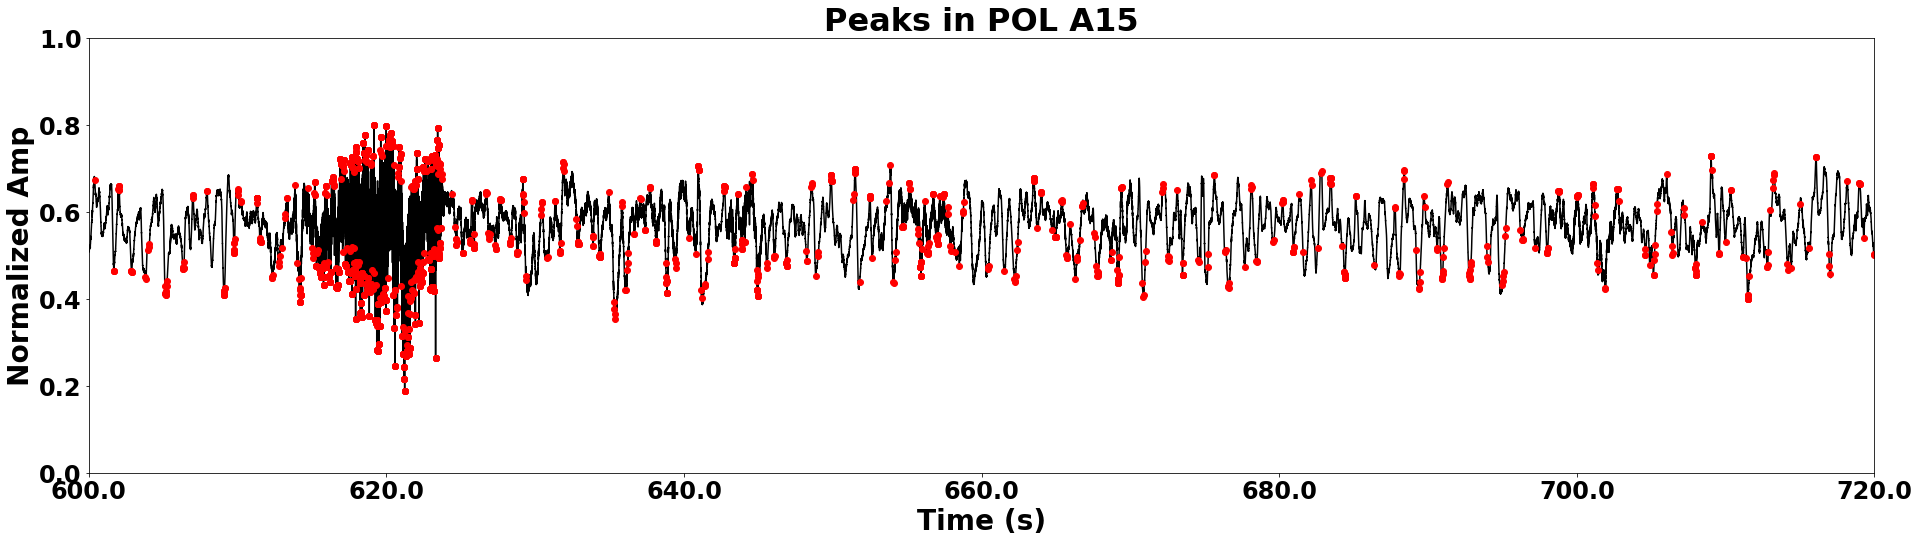

In [22]:
# set a timer
time_start=time.time()
fig_peak,ax_peak=plot_peak(max2min_t,peaks1_t,peaks2_t)
time_end=time.time()
print('Time spent in plotting is: '+str(np.round(time_end-time_start,2)))

In [23]:
# save it into local disk
f_path='E:/IEEE conference/Figures_final'
# save the figure into local disk
fig_peak_name='Fig1_3.svg'

fig_peak.savefig(os.path.join(f_path,fig_peak_name),dpi=300)

## 5.1 Set the threshold and get estimated output

Standard of thresholding

How to quantify the noise? 

1. From the power perspective. The average heat at this time point must be greater than 2 or 3 times greater than average.

2. From the frequency point of view. The high-power range spanned across all frequency range by the noise must be set over 50% or more. 

3. From the time-domain point of view. The density of peaks of noise must be siginificantly higher than normal ones.

As for the variance checking. It turns out that this condition won't help too much in terms of noise detection, consequently it was ignored and the corrsponding part did not reflect on the paper either.

Some necessary functions

1. fill_gap: to fill the gap if two detected noise events are within 1s range
2. padding_list: to extend 1s at the initial and final of the noise event if the noise events is long
3. update_list: to update the list after the detection

In [90]:
# create some helper functions to update the list
# fill the gap
def fill_gap(time_list):
    # make a copy
    new_list=time_list.copy()
    flag=0
    for i in range(len(time_list)-1):
        if time_list[i+1]-time_list[i]==2:
            ind_fill=i+1+flag
            num_fill=time_list[i]+1
            new_list.insert(ind_fill,num_fill)
            # update flag
            flag=flag+1
        else:
            pass
            
    return new_list

# pad the list if consecutive number is greater than 3
def padding_list(time_list):
    new_list=[]
    for k, g in groupby(enumerate(time_list),lambda ix:ix[0]-ix[1]):
        time_sub=list(map(itemgetter(1),g))
        if len(time_sub)>=3:
            time_sub=[time_sub[0]-1]+time_sub+[time_sub[-1]+1]
        # update the previous list
        new_list=new_list+time_sub
        
    return new_list

# update the time list
def update_list(time_list):
    # padding it first
    new_list=padding_list(time_list)
    # then to fill the gap
    new_list=fill_gap(new_list)
    
    return new_list

## 5.2 Get the detection results

Some parameters and save the result in a csv file.

The csv file was supposed to be implemented in the GUI and thus there were two columns to address the height and width. However, the start and end time were sufficient for normal use.

In [93]:
# set the threshold for heat
thresh_heat=2.5 # the average should be greater than 1
# set the threshold for occurance
thresh_cnt=60 # at least 60% of the spectrum should be covered
# retrieve parameters
num_clip=len(d_list)
num_ch=d_list[0].shape[0]
t_range=tmax-tmin
# create the dataframe
col_names=['ch_name','start_time','end_time','start_height','end_height']
df_preload=pd.DataFrame(columns=col_names)

# need to satisfy all of three conditions
# loop over all clips
for i in range(num_clip):
    # loop over all channels
    for j in range(num_ch):
        # retrieve previous info
        # from t-f plot
        heat=heat_win_t[i][j]
        cnt=cnt_win_t[i][j]
        heat_ind=np.where(heat>=thresh_heat)
        cnt_ind=np.where(cnt>=thresh_cnt)
        # get indicies based on power
        tf_ind=np.intersect1d(heat_ind,cnt_ind)
        
        # from time domain analysis
        max2min=max2min_t[i][j] # suppose to have length of 120/0.5
        # set the threshold for peak condition
        thresh_peak=np.floor(3.5*np.mean(max2min))
        peak_ind=[]
        # loop over max2min
        for k in range(len(max2min)):
            ind_low=int(k*0.2) # 0.2 is the stride in second
            ind_high=int(k*0.2+1) # 0.2 is the stride and 0.5 is the length of sliding window, both of them are in s
            if max2min[k]>=thresh_peak:
                peak_ind.append(ind_low)
                peak_ind.append(ind_high)
        
        # only keep unique entries
        peak_ind=list(np.unique(np.array(peak_ind)))
        var=var_t[i][j] # suppose to have length of 120/0.2
        # set the thresholding for variance condition
        thresh_var=1.25*np.mean(var)
        # reshape the var list
        var=np.reshape(var,newshape=(-1,5))
        var_ind=[]
        # loop over var
        for k in range(var.shape[0]):
            vote=np.sum((var[k,:]>=thresh_var)*1)
            if vote>2: # over half of them
                var_ind.append(k)
               
        # only keep unique entries
        var_ind=list(np.unique(np.array(var_ind)))       
        # get indicies based on time domain
        t_ind=np.intersect1d(var_ind,peak_ind)
        # get the overall index
        all_ind=np.intersect1d(tf_ind,peak_ind)
        times=all_ind
        # if there're two consective, just expand 1s from the head and the tail
        # loop over the times vector to get the result
        if len(times)==0:
            pass
        else: 
            # we need to update the list
            new_times=update_list(times)
            for item in new_times:
                ch_name=ch_names[j]
                start_time=item+i*t_range
                end_time=item+1+i*t_range
                # since this is the preload rectangle we then set height to 0.25 and the height is ficed to 0.2
                start_height=0.25+j
                end_height=start_height+0.2
                
                # append it into dataframe
                df_preload=df_preload.append({'ch_name':ch_name,'start_time':start_time,'end_time':end_time,
                                   'start_height':start_height,'end_height':end_height},ignore_index=True)
            
# save the dataframe back to the  local disk
print('The total number of noise detected is: '+str(df_preload.shape[0]))
f_name='FA0011HT_0_preload_rects.csv'
df_preload.to_csv(os.path.join(f_path,f_name),index=False)

The total number of noise detected is: 157
